Libraries imported.
Loading Session 750749662...


/opt/anaconda3/envs/TDA/lib/python3.11/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/opt/anaconda3/envs/TDA/lib/python3.11/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)
/opt/anaconda3/envs/TDA/lib/python3.11/site-packages

Selected 52 units from VISp


/opt/anaconda3/envs/TDA/lib/python3.11/site-packages/hdmf/spec/namespace.py:590: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.2.2, loaded version: 2.7.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


Calculating spike counts (Frames x Neurons)...
Final Neural Response Matrix Shape: (900, 52)
PCA Reduced Shape: (900, 50)
Running UMAP (3D)...
Final Neural Response Matrix Shape: (900, 52)
PCA Reduced Shape: (900, 50)
Running UMAP (3D)...


Running Ripser on 900 points...


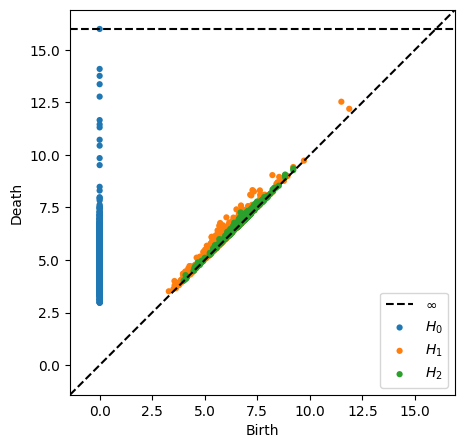

Interpretation:
- H0 (Blue): Connected components. Long bars = distinct clusters.
- H1 (Orange): Loops/Cycles. Long bars = significant loops.
- H2 (Green): Voids. Long bars = significant 3D voids.


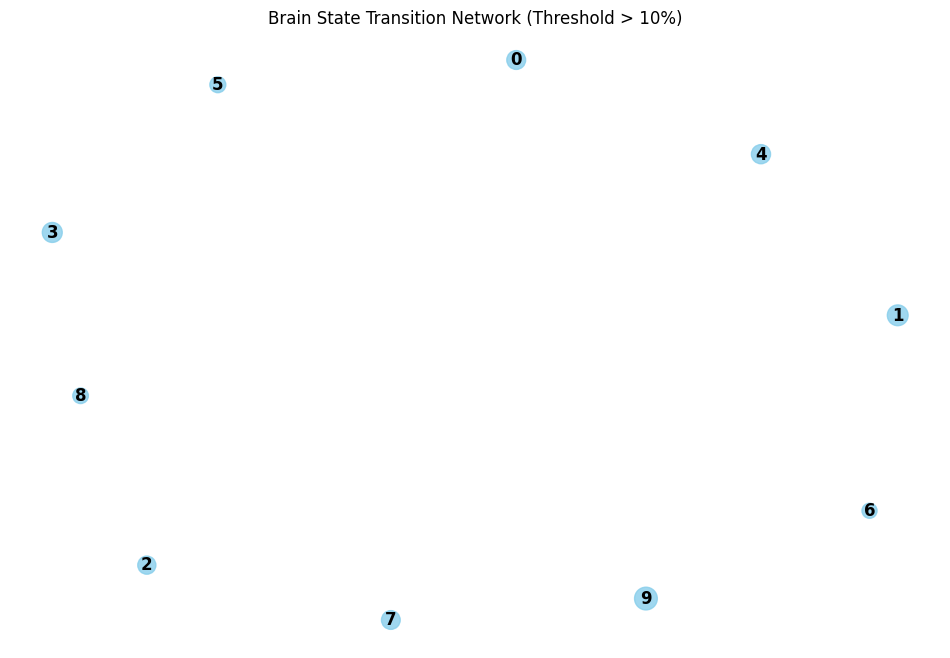

In [1]:
# --- 1. Imports & Setup ---
import os
import sys
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import h5py

# AllenSDK
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# Analysis & TDA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import umap
from ripser import ripser
from persim import plot_diagrams

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import networkx as nx

print("Libraries imported.")

# --- 2. Data Loading & Preprocessing ---
# Load Data
output_dir = "../Dataset/RAW"
manifest_path = os.path.join(output_dir, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

session_id = 750749662
print(f"Loading Session {session_id}...")
session = cache.get_session_data(session_id)

# Filter for VISp Units
visp_units = session.units[session.units["ecephys_structure_acronym"] == "VISp"]
print(f"Selected {len(visp_units)} units from VISp")

# Construct Neural Response Matrix (Natural Movie One)
movie_table = session.get_stimulus_table("natural_movie_one")
frame_duration = movie_table['duration'].mean()

print("Calculating spike counts (Frames x Neurons)...")
spike_counts_xr = session.presentationwise_spike_counts(
    stimulus_presentation_ids=movie_table.index.values,
    bin_edges=np.array([0, frame_duration]),
    unit_ids=visp_units.index.values
)

# Sum spikes within each frame window
response_matrix_all = spike_counts_xr.sum(dim="time_relative_to_stimulus_onset")

# Create DataFrame
df_response = pd.DataFrame(
    response_matrix_all.values,
    index=movie_table.index,
    columns=visp_units.index
)
df_response['frame'] = movie_table['frame']

# Average across repeats (if any) - Natural Movie One is usually repeated
average_response_matrix = df_response.groupby('frame').mean()

# Final Matrix: X (Frames x Neurons)
X = average_response_matrix.values
print(f"Final Neural Response Matrix Shape: {X.shape}")

# --- 3. PCA & UMAP ---
# PCA (Linear Reduction)
n_components_pca = 50
pca = PCA(n_components=n_components_pca)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))
print(f"PCA Reduced Shape: {X_pca.shape}")

# UMAP (Non-linear Visualization)
print("Running UMAP (3D)...")
reducer = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.1, random_state=42)
embedding_3d = reducer.fit_transform(X_pca)

# Visualize 3D UMAP
fig = px.scatter_3d(
    x=embedding_3d[:, 0], y=embedding_3d[:, 1], z=embedding_3d[:, 2],
    color=np.arange(len(embedding_3d)), # Color by time (frame index)
    title="3D UMAP of VISp Neural Activity (Natural Movie One)",
    labels={'color': 'Frame Index'}
)
fig.update_traces(marker=dict(size=3))
fig.show()

# --- 4. Topological Data Analysis (Ripser) ---
# Calculate H0 (Clusters), H1 (Loops), H2 (Voids)
X_tda = X_pca # Use full data

print(f"Running Ripser on {X_tda.shape[0]} points...")
result = ripser(X_tda, maxdim=2)
diagrams = result['dgms']

# Plot Persistence Diagrams
plt.figure(figsize=(10, 5))
plot_diagrams(diagrams, show=True)
plt.show()

print("Interpretation:")
print("- H0 (Blue): Connected components. Long bars = distinct clusters.")
print("- H1 (Orange): Loops/Cycles. Long bars = significant loops.")
print("- H2 (Green): Voids. Long bars = significant 3D voids.")

# --- 5. Cluster Transition Analysis ---
# Cluster the neural states
n_states = 10
kmeans = KMeans(n_clusters=n_states, random_state=42, n_init=10)
state_labels = kmeans.fit_predict(X_pca)

# Calculate Transitions
transition_matrix = np.zeros((n_states, n_states))
for t in range(len(state_labels) - 1):
    current_state = state_labels[t]
    next_state = state_labels[t+1]
    transition_matrix[current_state, next_state] += 1

# Normalize to probabilities
row_sums = transition_matrix.sum(axis=1)
transition_probs = np.divide(transition_matrix, row_sums[:, np.newaxis], out=np.zeros_like(transition_matrix), where=row_sums[:, np.newaxis]!=0)

# Visualize Network
G = nx.DiGraph()
for i in range(n_states):
    count = np.sum(state_labels == i)
    G.add_node(i, size=count)

threshold = 0.1
for i in range(n_states):
    for j in range(n_states):
        if i != j and transition_probs[i, j] > threshold:
            G.add_edge(i, j, weight=transition_probs[i, j])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1.5, seed=42)
node_sizes = [G.nodes[i]['size'] * 2 for i in G.nodes]
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
edges = G.edges()
weights = [G[u][v]['weight'] * 5 for u, v in edges]
nx.draw_networkx_edges(G, pos, width=weights, edge_color='gray', arrowsize=20, connectionstyle='arc3,rad=0.1')
plt.title(f"Brain State Transition Network (Threshold > {threshold*100:.0f}%)")
plt.axis('off')
plt.show()

Cluster 0 size for PH: (92, 3)


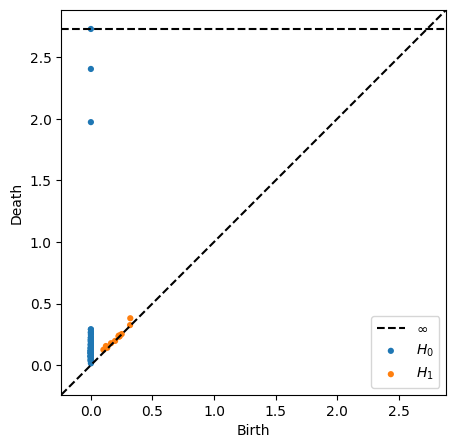

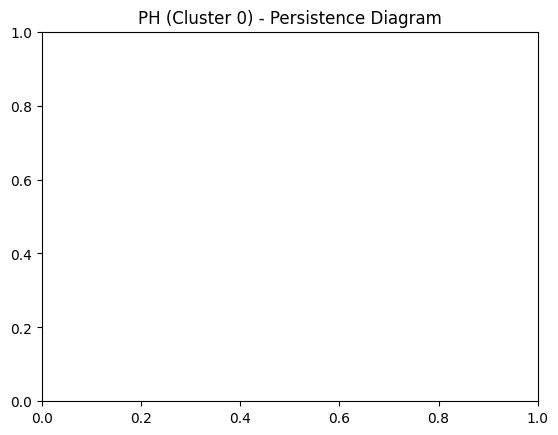

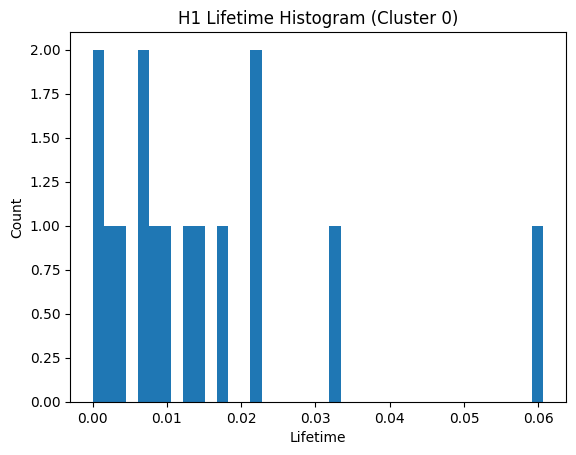

=== Persistent Homology Summary (Cluster 0) ===
Total H1 loops: 15
Significant H1 loops (>0.029): 2
Top significant loops:
 birth=0.320, death=0.381, life=0.061
 birth=0.122, death=0.155, life=0.033


In [3]:
# =====================================================================
# NOTE TO COPILOT:
# DO NOT MODIFY OR DELETE ANY EXISTING CODE ABOVE THIS LINE.
#
# BELOW, write a NEW independent code block that repeats the 
# persistent homology (PH) investigation we did earlier:
#   - extract Cluster 0
#   - compute PH using ripser (H0 + H1)
#   - plot barcode, persistence diagram, and lifetime histogram
#   - detect significant H1 loops
#
# IMPORTANT:
#   - This must NOT reuse or overwrite any previous variables, 
#     functions, or pipelines.
#   - Write everything in a new block (sequential code cells # %%).
#   - Use *new variable names* so nothing conflicts with earlier code.
# =====================================================================

# %%
# 1) 클러스터 0 데이터 추출 (새 변수 사용)
import numpy as np

cluster_id_ph = 0
mask_ph_c0 = (cluster_labels == cluster_id_ph)
X_ph_c0 = X_umap[mask_ph_c0]   # UMAP 좌표에서 cluster 0 가져오기

print("Cluster 0 size for PH:", X_ph_c0.shape)

# %%
# 2) Ripser로 PH 계산 (H0/H1)
from ripser import ripser
from persim import plot_diagrams

ph_result_c0 = ripser(X_ph_c0, maxdim=1)
dgm0_c0, dgm1_c0 = ph_result_c0["dgms"]

# %%
# 3) Persistence Diagram & Barcode 플롯
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plot_diagrams([dgm0_c0, dgm1_c0], show=True)
plt.title("PH (Cluster 0) - Persistence Diagram")
plt.show()

# %%
# 4) H1 lifetime 계산 + histogram 플롯
lifetimes_c0 = dgm1_c0[:, 1] - dgm1_c0[:, 0]
lifetimes_c0 = lifetimes_c0[lifetimes_c0 > 0]  # 0 이하 제거 (안정성)

plt.figure()
plt.hist(lifetimes_c0, bins=40)
plt.title("H1 Lifetime Histogram (Cluster 0)")
plt.xlabel("Lifetime")
plt.ylabel("Count")
plt.show()

# %%
# 5) Significant H1 loops 자동 검출
threshold_c0 = np.quantile(lifetimes_c0, 0.90)  # 상위 10%
sig_mask_c0 = lifetimes_c0 >= threshold_c0
sig_lifetimes_c0 = lifetimes_c0[sig_mask_c0]

# significant loops 정보 추출
dgm1_sig_c0 = dgm1_c0[sig_mask_c0]

print("=== Persistent Homology Summary (Cluster 0) ===")
print("Total H1 loops:", len(dgm1_c0))
print(f"Significant H1 loops (>{threshold_c0:.3f}):", len(dgm1_sig_c0))
print("Top significant loops:")
for b, d in dgm1_sig_c0[:10]:
    print(f" birth={b:.3f}, death={d:.3f}, life={d-b:.3f}")

Graph was disconnected. Using largest component: 83 nodes.
Coloring nodes by Frame index.


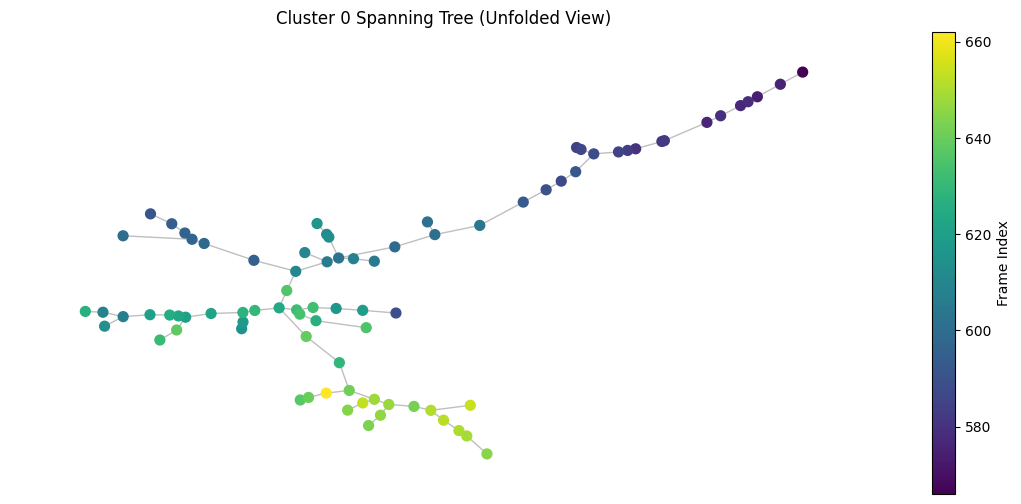

In [9]:
# =====================================================================
# NOTE TO COPILOT:
# DO NOT MODIFY OR DELETE ANY CODE ABOVE THIS LINE.
#
# Below, assume we already have:
#   - X_c0 : NumPy array of shape (N, d) with UMAP coordinates
#   - G    : networkx.Graph built from kNN on X_c0 (Cluster 0 only)
#
# Write NEW code cells (#%%) that:
#   1) Build a tree approximation of G (spanning tree)
#   2) Plot the tree using Kamada-Kawai layout (unfolded view).
#   3) Color nodes by Frame index.
#
# Do everything in new variables so the previous code is not affected.
# =====================================================================

# %%
# 1) G에서 spanning tree 만들기 (사이클 제거)
import networkx as nx

# spanning tree (최소 신장 트리)
T_full = nx.minimum_spanning_tree(G, weight="weight")

# 연결된 컴포넌트 중 가장 큰 것만 선택
if not nx.is_connected(T_full):
    largest_cc = max(nx.connected_components(T_full), key=len)
    T = T_full.subgraph(largest_cc).copy()
    print(f"Graph was disconnected. Using largest component: {T.number_of_nodes()} nodes.")
else:
    T = T_full
    print("Graph is connected. Nodes:", T.number_of_nodes())

# %%
# 2) 관계 중심의 그래프 시각화 (Unfolded/Long View) + Frame Color
import matplotlib.pyplot as plt

# Frame 정보 가져오기
if 'average_response_matrix' in locals() and 'mask_c0' in locals():
    all_frames = average_response_matrix.index.values
    frames_c0 = all_frames[mask_c0]
    
    nodelist = list(T.nodes())
    node_colors = [frames_c0[n] for n in nodelist]
    print("Coloring nodes by Frame index.")
    use_color = True
else:
    nodelist = list(T.nodes())
    node_colors = "skyblue"
    print("Frame info not found. Using default color.")
    use_color = False

# 길게 나타내기 위해 가로가 긴 figure 설정
plt.figure(figsize=(14, 6))

# Kamada-Kawai Layout: 그래프를 "구부리지 않고" 구조대로 펼치는 데 유리함
try:
    # scale을 키워서 더 넓게 퍼지도록 함
    pos_rel = nx.kamada_kawai_layout(T, scale=2.0)
except:
    print("Kamada-Kawai layout failed/missing. Using Spring layout.")
    pos_rel = nx.spring_layout(T, k=0.15, iterations=100, seed=42)

# 엣지 그리기
nx.draw_networkx_edges(T, pos_rel, edge_color="gray", alpha=0.5, width=1.0)

# 노드 그리기 (Frame 색상 적용)
if use_color:
    nodes = nx.draw_networkx_nodes(T, pos_rel, nodelist=nodelist, 
                                   node_size=50, 
                                   node_color=node_colors, 
                                   cmap=plt.cm.viridis, 
                                   label="Nodes")
    plt.colorbar(nodes, label="Frame Index")
else:
    nx.draw_networkx_nodes(T, pos_rel, nodelist=nodelist, 
                           node_size=50, 
                           node_color=node_colors, 
                           label="Nodes")

# Branch/Leaf 노드 별도 라벨링 제거 (요청사항 반영)

plt.title("Cluster 0 Spanning Tree (Unfolded View)")
plt.axis("off")
plt.show()

Building graph for ALL frames...
Full Graph disconnected. Using largest component: 557/900 nodes.
Computing layout for full graph...


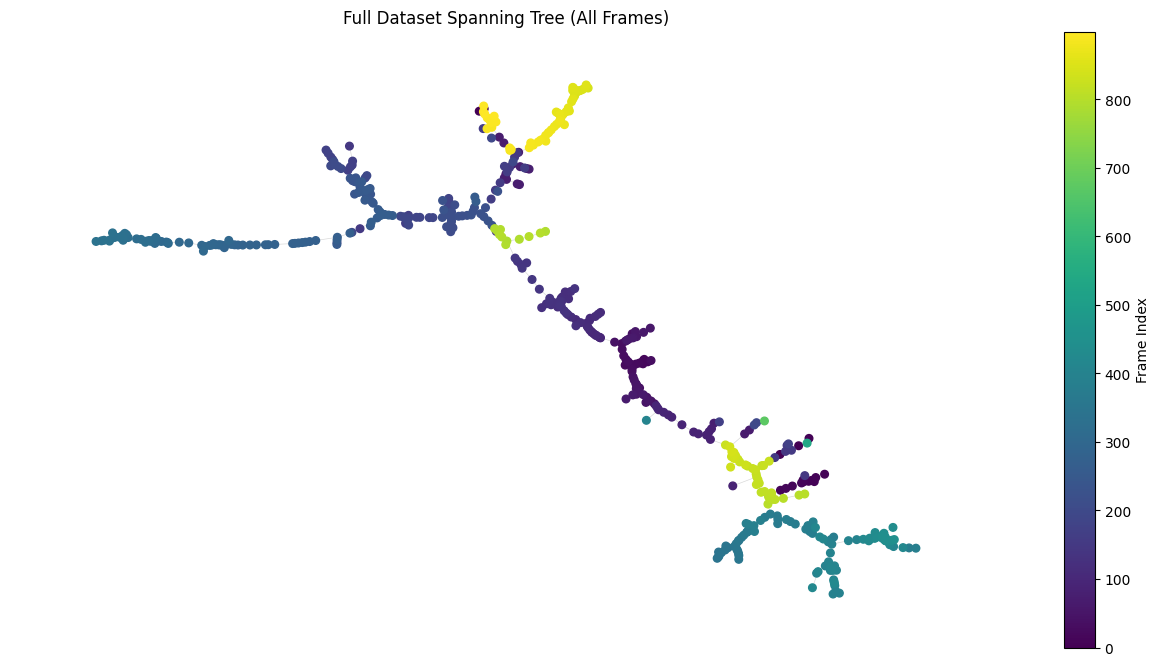

In [10]:
# =====================================================================
# NOTE TO COPILOT:
# DO NOT MODIFY OR DELETE ANY CODE ABOVE THIS LINE.
#
# BELOW, write a NEW independent code block that performs the same
# graph construction and visualization for the ENTIRE dataset (all frames).
#   1) Build kNN graph on full X_umap.
#   2) Build spanning tree.
#   3) Plot using Kamada-Kawai layout with Frame coloring.
# =====================================================================

# %%
# 1) 전체 데이터에 대해 kNN 그래프 및 Spanning Tree 생성
print("Building graph for ALL frames...")

# 전체 데이터 사용
X_all = X_umap
k_all = 10

# kNN Graph 생성
nbrs_all = NearestNeighbors(n_neighbors=k_all + 1).fit(X_all)
dists_all, inds_all = nbrs_all.kneighbors(X_all)

G_all = nx.Graph()
num_all = X_all.shape[0]
G_all.add_nodes_from(range(num_all))

# Edge 추가 (Self-loop 제외)
for i in range(num_all):
    for d, j in zip(dists_all[i][1:], inds_all[i][1:]):
        G_all.add_edge(i, j, weight=float(d))

# Spanning Tree (MST)
T_all_full = nx.minimum_spanning_tree(G_all, weight="weight")

# 연결된 컴포넌트 확인
if not nx.is_connected(T_full):
    largest_cc_all = max(nx.connected_components(T_all_full), key=len)
    T_all = T_all_full.subgraph(largest_cc_all).copy()
    print(f"Full Graph disconnected. Using largest component: {T_all.number_of_nodes()}/{num_all} nodes.")
else:
    T_all = T_all_full
    print(f"Full Graph connected. Nodes: {T_all.number_of_nodes()}")

# %%
# 2) 전체 프레임 그래프 시각화 (Unfolded View)
plt.figure(figsize=(16, 8))

# Frame 정보 (전체)
if 'average_response_matrix' in locals():
    frames_all = average_response_matrix.index.values
    # T_all에 있는 노드만 선택 (혹시 disconnected node가 빠졌을 경우 대비)
    nodelist_all = list(T_all.nodes())
    colors_all = [frames_all[n] for n in nodelist_all]
    use_color_all = True
else:
    nodelist_all = list(T_all.nodes())
    colors_all = "skyblue"
    use_color_all = False

# Layout 계산 (시간이 좀 걸릴 수 있음)
print("Computing layout for full graph...")
try:
    pos_all = nx.kamada_kawai_layout(T_all, scale=2.0)
except:
    print("Kamada-Kawai failed. Using Spring layout.")
    pos_all = nx.spring_layout(T_all, k=0.1, iterations=50, seed=42)

# 그리기
nx.draw_networkx_edges(T_all, pos_all, edge_color="gray", alpha=0.3, width=0.5)

if use_color_all:
    nodes = nx.draw_networkx_nodes(T_all, pos_all, nodelist=nodelist_all, 
                                   node_size=30, 
                                   node_color=colors_all, 
                                   cmap=plt.cm.viridis, 
                                   label="Nodes")
    plt.colorbar(nodes, label="Frame Index")
else:
    nx.draw_networkx_nodes(T_all, pos_all, nodelist=nodelist_all, 
                           node_size=30, 
                           node_color=colors_all)

plt.title("Full Dataset Spanning Tree (All Frames)")
plt.axis("off")
plt.show()

Labeling Branch/Leaf nodes with Frame indices...
Total Branch nodes: 121
Total Leaf nodes: 135


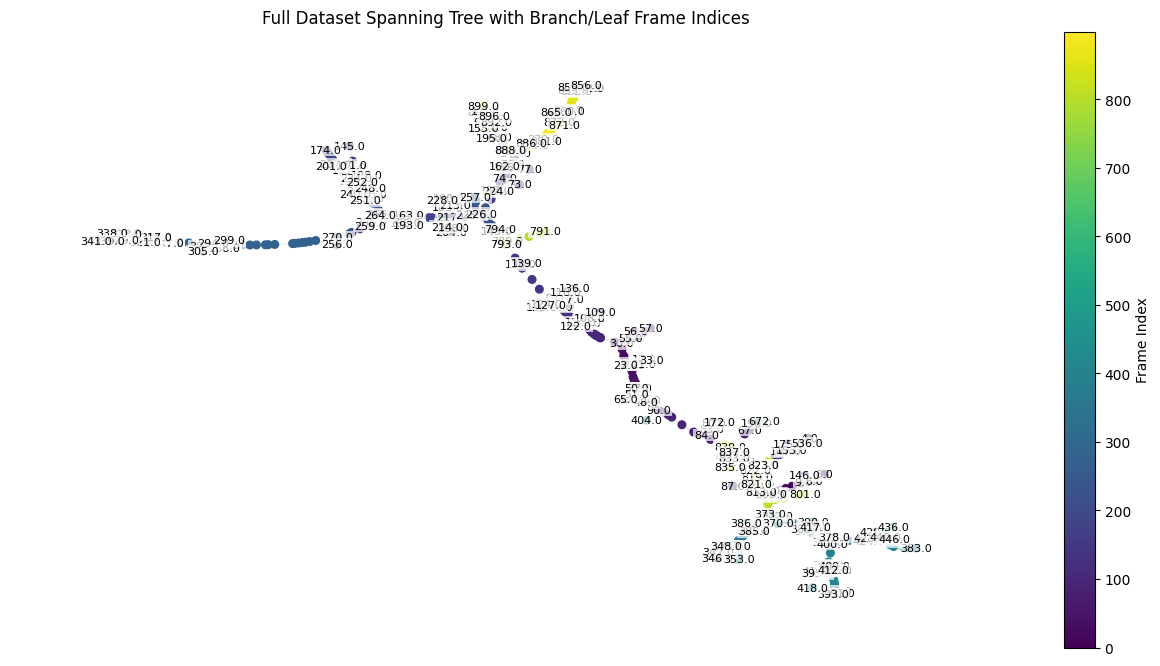

In [11]:
# =====================================================================
# NOTE TO COPILOT:
# DO NOT MODIFY OR DELETE ANY CODE ABOVE THIS LINE.
#
# BELOW, write a NEW independent code block that:
#   1) Identifies branch and leaf nodes in the full tree (T_all).
#   2) Re-plots the graph (using pos_all).
#   3) Overlays the FRAME INDEX as text labels for only branch/leaf nodes.
# =====================================================================

# %%
# 3) Branch/Leaf 노드의 Frame Index 라벨링
print("Labeling Branch/Leaf nodes with Frame indices...")

# Branch/Leaf 식별
degrees_all = dict(T_all.degree())
branch_nodes_all = [n for n, deg in degrees_all.items() if deg >= 3]
leaf_nodes_all = [n for n, deg in degrees_all.items() if deg == 1]

print(f"Total Branch nodes: {len(branch_nodes_all)}")
print(f"Total Leaf nodes: {len(leaf_nodes_all)}")

plt.figure(figsize=(16, 8))

# 1. 기존 그래프 그리기 (배경)
nx.draw_networkx_edges(T_all, pos_all, edge_color="gray", alpha=0.3, width=0.5)
if use_color_all:
    nodes = nx.draw_networkx_nodes(T_all, pos_all, nodelist=nodelist_all, 
                                   node_size=30, 
                                   node_color=colors_all, 
                                   cmap=plt.cm.viridis)
    plt.colorbar(nodes, label="Frame Index")
else:
    nx.draw_networkx_nodes(T_all, pos_all, nodelist=nodelist_all, 
                           node_size=30, 
                           node_color=colors_all)

# 2. 라벨 준비 (Branch + Leaf)
labels_to_draw = {}
# Branch nodes
for n in branch_nodes_all:
    frame_idx = frames_all[n]
    labels_to_draw[n] = str(frame_idx)

# Leaf nodes
for n in leaf_nodes_all:
    frame_idx = frames_all[n]
    labels_to_draw[n] = str(frame_idx)

# 3. 라벨 그리기
# 텍스트가 잘 보이도록 배경색(bbox) 추가
nx.draw_networkx_labels(T_all, pos_all, labels=labels_to_draw, 
                        font_size=8, font_color='black',
                        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1))

plt.title("Full Dataset Spanning Tree with Branch/Leaf Frame Indices")
plt.axis("off")
plt.show()

Plotting graph with image overlays (offset to reduce overlap)...
Selected 25 branches and 25 leaves for visualization.


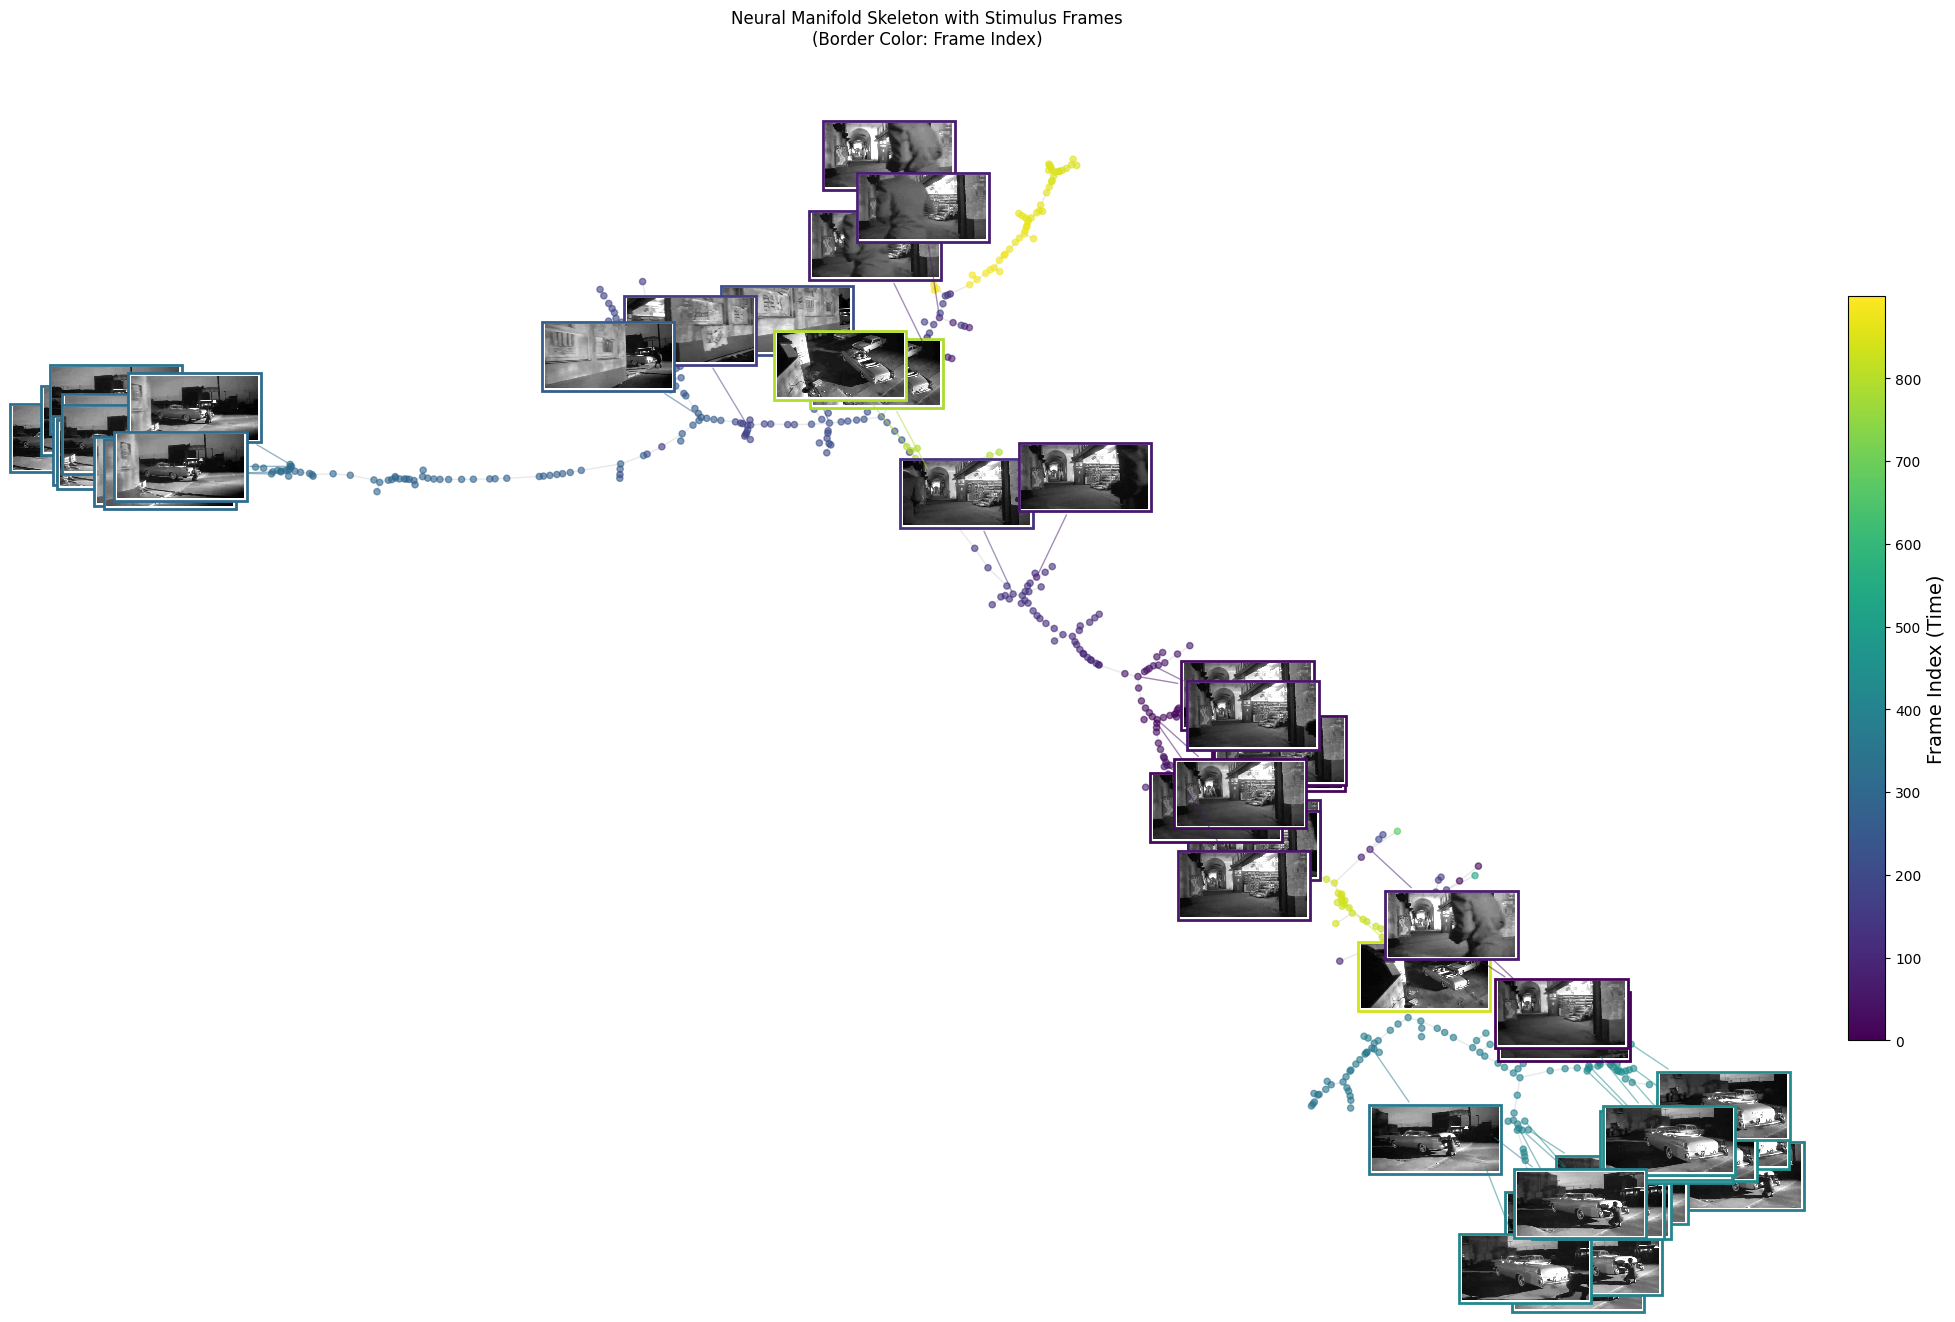

In [21]:
# %%
# 5) 그래프 위에 중요 노드(Branch/Leaf)의 프레임 이미지 오버레이
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np

print("Plotting graph with image overlays (offset to reduce overlap)...")

fig, ax = plt.subplots(figsize=(24, 16))

# 1. 기본 그래프 그리기
# Edge
nx.draw_networkx_edges(T_all, pos_all, edge_color="lightgray", alpha=0.5, width=1.0, ax=ax)
# Node (전체 노드를 작게 표시)
if use_color_all:
    nx.draw_networkx_nodes(T_all, pos_all, nodelist=nodelist_all, 
                           node_size=20, 
                           node_color=colors_all, 
                           cmap=plt.cm.viridis, 
                           alpha=0.6,
                           ax=ax)
else:
    nx.draw_networkx_nodes(T_all, pos_all, nodelist=nodelist_all, 
                           node_size=20, 
                           node_color='skyblue', 
                           alpha=0.6,
                           ax=ax)

# 중심점 계산 (이미지를 바깥쪽으로 밀어내기 위함)
pos_values = np.array(list(pos_all.values()))
center_pos = np.mean(pos_values, axis=0)

# Colormap 설정 (Frame Index에 따른 색상)
norm = plt.Normalize(vmin=np.min(frames_all), vmax=np.max(frames_all))
cmap = plt.cm.viridis

# 2. 이미지 오버레이 함수 (Offset 기능 추가)
def add_image_node(node_idx, ax, border_color=None):
    frame_idx = int(frames_all[node_idx])
    
    # 색상이 지정되지 않았으면 Frame Index에 따라 결정
    if border_color is None:
        border_color = cmap(norm(frame_idx))
    
    # 이미지 데이터 가져오기
    if 0 <= frame_idx < movie_template.shape[0]:
        img_data = movie_template[frame_idx]
        
        # 노드 위치 및 오프셋 계산
        node_pos = pos_all[node_idx]
        vec = node_pos - center_pos
        dist = np.linalg.norm(vec)
        
        # 중심에서 바깥쪽으로 밀어냄
        if dist > 0:
            direction = vec / dist
        else:
            direction = np.array([1, 1]) / np.sqrt(2)
            
        # 약간의 랜덤성을 주어 겹침 방지 (회전)
        rand_angle = np.random.uniform(-0.3, 0.3)
        c, s = np.cos(rand_angle), np.sin(rand_angle)
        rot_mat = np.array([[c, -s], [s, c]])
        direction = np.dot(rot_mat, direction)
        
        offset_scale = 80  # 거리 (points)
        offset = direction * offset_scale
        
        # OffsetImage (zoom 확대: 0.15)
        imagebox = OffsetImage(img_data, zoom=0.15, cmap='gray')
        
        # AnnotationBbox
        ab = AnnotationBbox(imagebox, node_pos, 
                            xybox=offset,
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="-", color=border_color, alpha=0.5),
                            frameon=True, pad=0.2,
                            bboxprops=dict(edgecolor=border_color, linewidth=2))
        ax.add_artist(ab)

# 3. Branch 및 Leaf 노드 중 중요 노드 선별 (이미지 과밀 방지)
# Branch: 차수(degree)가 높은 순으로 상위 25개 선택 (주요 분기점)
sorted_branches = sorted(branch_nodes_all, key=lambda n: T_all.degree(n), reverse=True)
top_branches = sorted_branches[:25]

# Leaf: 그래프 중심에서 가장 멀리 떨어진(extreme) 순으로 상위 25개 선택 (주요 끝점)
leaf_distances = [(n, np.linalg.norm(pos_all[n] - center_pos)) for n in leaf_nodes_all]
sorted_leaves = sorted(leaf_distances, key=lambda x: x[1], reverse=True)
top_leaves = [n for n, dist in sorted_leaves[:25]]

print(f"Selected {len(top_branches)} branches and {len(top_leaves)} leaves for visualization.")

# Branch (Frame Color)
for n in top_branches:
    add_image_node(n, ax)

# Leaf (Frame Color)
for n in top_leaves:
    add_image_node(n, ax)

# Add Colorbar for Frame Index
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.01)
cbar.set_label("Frame Index (Time)", fontsize=14)

plt.title("Neural Manifold Skeleton with Stimulus Frames\n(Border Color: Frame Index)")
plt.axis("off")
plt.show()